# Saqeeb's Pokedex


Welcome to my own personal Pokedex, where I'll be using a residual neural network to build a classifier that can identify any of the original 151 pokemon!


First, we need to grab the data. Luckily there is already a nice dataset on kaggle.com.
It is, however, missing two pokemon: the male and female nidorans. I'm planning to gather the data for this later. Right now we'll be training with 149 classes.


In [1]:
import scipy
import cv2
import opendatasets as od

# dataset_url = 'https://www.kaggle.com/thedagger/pokemon-generation-one' # You will need a kaggle token for this
# od.download(dataset_url)

In [2]:
import os

# DATA_DIR = './pokemon-generation-one/dataset'
DATA_DIR = 'temp-datasets'
classes = os.listdir(DATA_DIR)
print(classes)
num_classes = len(classes)
num_classes

['Bulbasaur', 'Charmander', 'Fearow', 'Mewtwo', 'Pikachu', 'Psyduck', 'Spearow', 'Squirtle']


8

To normalize the images, we first have to calculate the mean and standard deviation of the dataset. This takes a while and is bottlenecked by my HDD, so we'll try to read it from a file, and if the file doesn't exist, we'll calculate it manually and save it to a file for next time.

In [3]:
import json
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt


def mean_std(batch):
    '''Calculate the means and standard deviations of all images in a batch by colour channel'''
    images, labels = next(iter(batch))
    # shape of images = [b,c,w,h]
    mean, std = images.mean([0,2,3]), images.std([0,2,3])
    return mean, std

try:
    with open('stats.data', 'r') as filehandle: # open file for reading
        stats = json.load(filehandle)
    print("Loaded mean and standard deviation from file.")
    print(stats)
    mean, std = stats
    write = False
except:
    print("stats.data does not exist in the root directory. Calculating the mean and standard deviation:")
    write = True

if write:
    # Create a temporary dataset to get the mean and std

    image_size = 128

    stats_tfms = tt.Compose([tt.Resize(image_size),
                            tt.CenterCrop(image_size),
                            tt.ToTensor()])

    stats_set = ImageFolder(DATA_DIR, stats_tfms)
    dl = DataLoader(stats_set, batch_size=len(stats_set))

    mean, std = mean_std(dl)
    stats = mean.tolist(), std.tolist()
    print(stats)

    with open('stats.data', 'w') as filehandle: # open file for writing
        json.dump((stats), filehandle)
    print("Stats saved in stats.data.")

Loaded mean and standard deviation from file.
[[0.6235154271125793, 0.6207897067070007, 0.5437915325164795], [0.3592913746833801, 0.33420315384864807, 0.36002641916275024]]


Now we need to standardize the dataset in terms of image size. Due to memory constraints, each image should be no more than 128x128 pixels. Below, I create two instances of the dataset. That's because I don't have the files separated into training and validations sets, so instead I applied two random_split()s with the same seed. This allows for the training and validation sets to have different transformations/augmentations applied to them.

In [4]:
image_size = 128
batch_size = 64
stats = mean, std

train_tfms = tt.Compose([tt.Resize(image_size),
                         # tt.Resize(image_size, max_size=image_size),
                         # tt.Pad(padding=[(128 - image[0])/2 if image[0]<128 else 0, (128 - image[1])/2 if image[1]<128 else 0]),
                         tt.CenterCrop(image_size),
                         tt.RandomCrop(image_size, padding=8, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         # tt.RandomRotate
                         # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
                         # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

valid_tfms = tt.Compose([tt.Resize(image_size),
                         tt.CenterCrop(image_size),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])

dataset  = ImageFolder(DATA_DIR, train_tfms)
dataset2 = ImageFolder(DATA_DIR, valid_tfms)


Now we split the dataset into training and validation sets, with a seed for consistency and reproducibility.

In [5]:
from torch.utils.data import random_split

random_seed = 42
torch.manual_seed(random_seed);

valid_percent = 0.2
valid_size = int(valid_percent * len(dataset))
train_size = len(dataset) - valid_size

train_ds,  valid_ds  = random_split(dataset,  [train_size, valid_size]) # has the train_tfms transforms

torch.manual_seed(random_seed);
train_ds2, valid_ds2 = random_split(dataset2, [train_size, valid_size]) # has the valid_tfms transforms

del train_ds2
del valid_ds

len(train_ds), len(valid_ds2), len(dataset) # Sanity check

(1502, 375, 1877)

We also want to be able to do some analytics and figure out the best way to tune our model. Let's record the number of examples in each class.

In [6]:
count = False
if 'total_examples_per_class' not in locals(): count = True


def count_examples(train_dataset, valid_dataset):
    train_examples_per_class = [0] * num_classes
    valid_examples_per_class = [0] * num_classes
    total_examples_per_class = [0] * num_classes

    for _, label in train_dataset:
        train_examples_per_class[label] += 1
        total_examples_per_class[label] += 1

    for _, label in valid_dataset:
        valid_examples_per_class[label] += 1
        total_examples_per_class[label] += 1
    return train_examples_per_class, valid_examples_per_class, total_examples_per_class

if count:
    train_per_class, valid_per_class, total_per_class = count_examples(train_ds, valid_ds2)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:976: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In case we want to weight our loss function according to class sizes, lets create a class_weights tensor.

In [7]:
import numpy as np
class_weights = 100*torch.tensor(np.divide(1, train_per_class), dtype=torch.float)
print(train_per_class)
print(class_weights)

[239, 227, 93, 257, 236, 120, 108, 222]
tensor([0.4184, 0.4405, 1.0753, 0.3891, 0.4237, 0.8333, 0.9259, 0.4505])


Now let's set up some data loaders. I'll start with a batch size of 64, and increase it if it's training too slowly and I have extra GPU memory.

In [8]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds2, batch_size*2, num_workers=4, pin_memory=True)

Let's take a look at some of the images to make sure nothing went wrong so far.

In [9]:
from torchvision.utils import make_grid
# %matplotlib widget
import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt



def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means
    # return (images-means)/stds

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

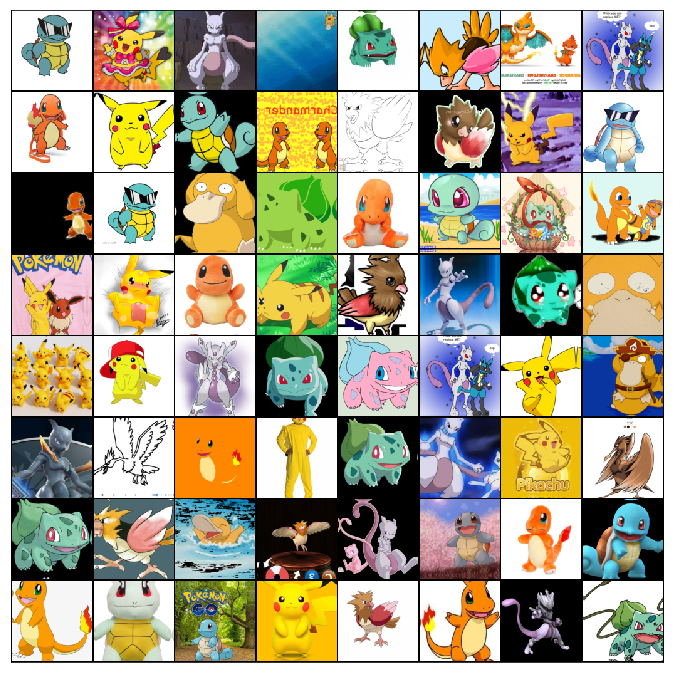

In [10]:
show_batch(train_dl)

In [11]:
# for images, labels in train_dl: # Sanity check
#     print(images.shape)
#     break

## Loading data onto the GPU

Alright, we've got all our data formatted and ready to go! Let's load everything onto the GPU.

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We created a wrapper `DeviceDataLoader` to wrap around our dataloaders and transfer them to the GPU. I think this code came from fast.ai.

In [13]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

class_weights = to_device(class_weights, device)

cuda


## Creating the model

We'll start with a 9 layer ResNet as described [here](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet/). The layers are shown in this image:

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

First, let's define a base classification class that has useful methods for reporting the performance of the model.

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassification(nn.Module):
    # The constructor will go in the child class
    def training_loss(self, batch):
        images, labels = batch
        predictions = self(images)                  # get predictions
        loss = F.cross_entropy(predictions, labels) # calculate loss
        return loss

    def validation_loss(self, batch):
        images, labels = batch
        predictions = self(images)                  # get predictions
        loss = F.cross_entropy(predictions, labels, weight=class_weights) # calculate loss
        acc = accuracy(predictions, labels)         # calculate accuracy
        return {"val_loss": loss.detach(), 'val_acc': acc}

    def validation_epoch_stats(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        batch_accs   = [x['val_acc']  for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        epoch_acc  = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss_epoch': epoch_loss.item(), 'val_acc_epoch': epoch_acc.item()}

    def report_epoch_performance(self, epoch, result):
        print("Epoch {:4} learning rate: {:.5f}, trainLoss: {:.4f}, valLoss: {:.4f}, valAcc: {:.4f}".format(
            str(epoch+1)+',', result['lrs'][-1], result['train_loss'], result['val_loss_epoch'], result['val_acc_epoch']))

# Need to define the accuracy function called above
def accuracy(predictions, labels):
    # input 'predictions' is an array of batch_index * class_probabilities
    _, predictions = torch.max(predictions, dim=1)  # get index of max probability
    acc = torch.sum(predictions == labels).item() / len(predictions)
    return torch.tensor(acc)

Next we expand this class with the model architecture. The ResNet9 architecture follows up each convolution with a batch normalization and ReLU, and sometimes a max pool. Let's define a function that simplifies this.

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn. ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

Let's create a ResNet9 model:

Note: This is really a ResNet13 now, I was getting very poor performance with the ResNet9 model

In [16]:
class ResNet9(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.conv5 = conv_block(512, 512, pool=True)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classify = nn.Sequential(nn.MaxPool2d(4),
                                      # nn.MaxPool2d(2),
                                      # nn.MaxPool2d(2),
                                      nn.Flatten(),
                                      nn.Dropout(0.2),
                                      nn.Linear(512, num_classes),
                                      nn.Softmax(dim=1)
                                      )
        
    def forward(self, image_batch):
        out = self.conv1(image_batch)
        out = self.conv2(out)
        out = self.res1(out) + out # Residual Layer
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out

        # These three lines make it 13 layers
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out

        out = self.classify(out)

        return out



Or we can import a predefined ResNet and see how that works. We'll extend the ImageClassification class with a ResNet network. Actually let's make several classes and choose which to use later.

In [17]:
import torchvision.models as models

pretrained = False

class ResNet50(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = models.resnet50(pretrained=pretrained)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image_batch):
        out = self.network(image_batch)
        return self.softmax(out)

class ResNet152(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = models.resnet152(pretrained=pretrained)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image_batch):
        out = self.network(image_batch)
        return self.softmax(out)

class ResNext50_32x4d(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = models.resnext50_32x4d(pretrained=pretrained)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image_batch):
        out = self.network(image_batch)
        return self.softmax(out)

class WideResNet50_2(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = models.wide_resnet50_2(pretrained=pretrained)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image_batch):
        out = self.network(image_batch)
        return self.softmax(out)

class WideResNet101_2(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.network = models.wide_resnet101_2(pretrained=pretrained)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image_batch):
        out = self.network(image_batch)
        return self.softmax(out)

In [18]:
model = to_device(ResNet152(3, num_classes), device)
# model

Alright, we've defined our model. Next we have to set up our training loop. We'll be training with learning rate scheduling, weight decay, and gradient clipping. Hopefully this will get us to a good loss minimum without overfitting.

In [19]:
def fit(model, train_loader, valid_loader, num_epochs, max_lr, 
        weight_decay=0, grad_clip=None, opt_func = torch.optim.SGD, stop_pct=None):
    torch.cuda.empty_cache()
    history = []

    # Set up optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Set up the learning rate scheduler (one-cycle learning rate)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs, 
                                                steps_per_epoch=len(train_loader))

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        lrs = []
        # Training step
        for batch in train_loader:
            loss = model.training_loss(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()

            # Record and update learning rate
            lrs.append(get_lr(optimizer))       # Need to define this function
            sched.step()
        
        # Validation Phase - report performance stats for each epoch
        result = evaluate(model, valid_loader)  # Need to define this function
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.report_epoch_performance(epoch, result)
        history.append(result)
        if stop_pct:
            if history[-1]['val_acc_epoch'] >= stop_pct:
                print("Validation accuracy passed 97%, stopping training.")
                break
    return history

@torch.no_grad()
def get_lr(optimizer):
    for param_group in optimizer.param_groups:  # I don't understand how this works
        return param_group['lr']

@torch.no_grad()
def evaluate(model, valid_loader):
    model.eval()
    outputs = [model.validation_loss(batch) for batch in valid_loader]
    return model.validation_epoch_stats(outputs)


In [20]:
clear_cache = True

if clear_cache: torch.cuda.empty_cache()

history = [evaluate(model, valid_dl)]
history

[{'val_acc_epoch': 0.07729341834783554, 'val_loss_epoch': 2.1231849193573}]

We are now ready to train the model! We'll use the adam optimizer along with the following hyperparameters:

In [24]:
num_epochs = 1000
max_lr = 0.0001
grad_clip = None #0.01
weight_decay = 0 #3e-3
opt_func = torch.optim.Adam
stop_pct = 0.95

In [25]:
%%time
history += fit(model, train_dl, valid_dl, num_epochs, max_lr, weight_decay, grad_clip, opt_func, stop_pct)

Epoch 1,   learning rate: 0.00000, trainLoss: 1.5856, valLoss: 1.7657, valAcc: 0.6544
Epoch 2,   learning rate: 0.00000, trainLoss: 1.5825, valLoss: 1.7731, valAcc: 0.6440
Epoch 3,   learning rate: 0.00000, trainLoss: 1.5895, valLoss: 1.7692, valAcc: 0.6492
Epoch 4,   learning rate: 0.00000, trainLoss: 1.5820, valLoss: 1.7731, valAcc: 0.6466
Epoch 5,   learning rate: 0.00000, trainLoss: 1.5834, valLoss: 1.7748, valAcc: 0.6440
Epoch 6,   learning rate: 0.00000, trainLoss: 1.5879, valLoss: 1.7730, valAcc: 0.6466
Epoch 7,   learning rate: 0.00000, trainLoss: 1.5754, valLoss: 1.7649, valAcc: 0.6574
Epoch 8,   learning rate: 0.00000, trainLoss: 1.5843, valLoss: 1.7664, valAcc: 0.6544
Epoch 9,   learning rate: 0.00000, trainLoss: 1.5817, valLoss: 1.7680, valAcc: 0.6546
Epoch 10,  learning rate: 0.00000, trainLoss: 1.5787, valLoss: 1.7694, valAcc: 0.6518
Epoch 11,  learning rate: 0.00000, trainLoss: 1.5732, valLoss: 1.7686, valAcc: 0.6518
Epoch 12,  learning rate: 0.00000, trainLoss: 1.5713, 

I'd like to save my hyperparameters for training runs that had good results. We can save this to a file, and in the future we can look at this file in its git commit and grab the values. We can also save the model parameters using a pytorch `state_dict()`.

In [88]:
save = False
# load = True

filename = 'params/wideResNet152-8pokemon-hypers'

if save:
    hyperparams = {'num_epochs': num_epochs,
                'max_lr': max_lr,
                'grad_clip': grad_clip,
                'weight_decay': weight_decay,
                'opt_func': torch.optim.Adam,
                'history': history,
                #'model': model.state_dict(),
                'val_accuracy': history[-1]['val_acc_epoch'],
                'train_loss': history[-1]['train_loss'],
                'val_loss': history[-1]['val_loss_epoch']
                }

    torch.save(hyperparams, filename+'.pth')
    # torch.save(model.state_dict(), filename+'params.pth')

# if load:
#     hyperparams = torch.load(filename+'.pth')
#     history = hyperparams['history']
#     model2 = to_device(ResNet9(3, num_classes), device)
#     model2.load_state_dict(torch.load(filename+'params.pth'))

# print(filename)

# print(evaluate(model, valid_dl))
torch.save(model.state_dict(), 'params/wideResNet152-8pokemon-model.pth')

In [ ]:
model2 = to_device(ResNet152(3, num_classes), device)
model2.load_state_dict(torch.load('params/paramsResNet152.pth'))
print(evaluate(model2, valid_dl))

Let's visualize the accuracy and losses of the model over time.

In [27]:
def plot_accuracies(history):
    accuracies = [x['val_acc_epoch'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

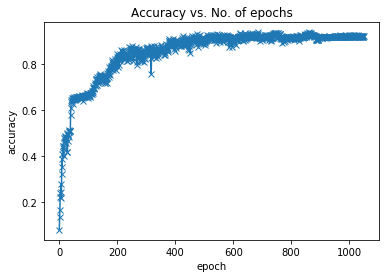

In [28]:
plot_accuracies(history)

In [29]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss_epoch'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

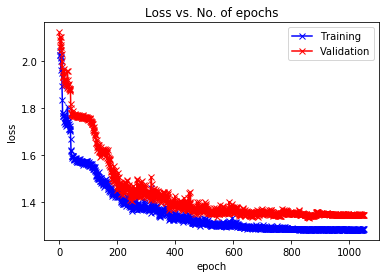

In [30]:
plot_losses(history)

## Confusion Matrix Analytics

We also want to know things like:
* The accuracy of predicting each class vs the number of training examples in that class
* Which classes have the most false positives
* Which classes have the poorest performance
* Which classes get mistaken by which other classes most often

Most of these can be calculated from a confusion matrix, so let's create one.

In [31]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)

    # Get predictions from model
    yb = model(xb)

    # Pick index with highest probability
    # _, preds  = torch.max(yb, dim=1)

    # Sort predictions to get most likely predictions
    probs, pred = torch.sort(yb, dim=1, descending=True)
    
    return probs[0].tolist(), pred[0].tolist()

In [32]:
def confusion_matrix(model, valid_dataset, num_classes):
    matrix = to_device(torch.zeros(num_classes, num_classes), device)
    # dimensions will be true labels * predictions
    for image, label in valid_dataset:
        _, predictions = predict_image(image, model)
        matrix[label][predictions[0]] += 1
    
    return matrix

In [33]:
matrix = confusion_matrix(model, valid_ds2, num_classes)

In [34]:
matrix

tensor([[48.,  0.,  0.,  0.,  0.,  0.,  1.,  1.],
        [ 0., 63.,  2.,  0.,  0.,  0.,  1.,  3.],
        [ 0.,  0., 28.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., 47.,  0.,  0.,  1.,  1.],
        [ 0.,  1.,  0.,  0., 54.,  3.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0., 38.,  0.,  1.],
        [ 1.,  0.,  0.,  1.,  0.,  0., 20.,  0.],
        [ 5.,  3.,  1.,  0.,  0.,  0.,  0., 48.]], device='cuda:0')

Let's define some functions for plotting analytics:

In [ ]:
print(train_per_class)
print(valid_per_class)

In [ ]:
print(matplotlib.rcParams['backend'])

In [35]:
import pandas as pd
# matplotlib.style.use('ggplot') # This was a mistake

# To solve the plt.ylabel "str object is not callable" error
# from importlib import reload
# reload(plt)

def accuracy_per_class(confusion_matrix):
    totals = torch.sum(confusion_matrix, dim=1)
    return torch.div(torch.diag(confusion_matrix), totals).tolist()

def plot_accuracy_vs_examples(acc_per_class, train_per_class):
    plt.plot(train_per_class, acc_per_class, 'bx')
    plt.ylim([0,1])
    plt.xlim([0, max(train_per_class)+10])
    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy on validation set")
    plt.grid()

def plot_acc_vs_class(acc_per_class, classes, sorted=False):
    df = pd.DataFrame({'acc_per_class': acc_per_class, 'classes': classes})
    if sorted:
        df.sort_values('acc_per_class', inplace=True)
    df.plot(kind='bar', x='classes', legend=False, title='Class Accuracies', rot=90, figsize=(30,5))
    plt.ylabel('Accuracies')

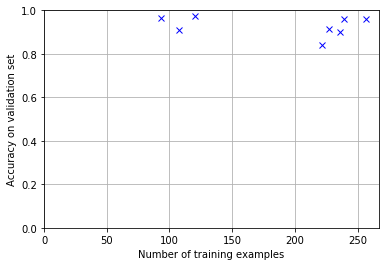

In [36]:
acc_per_class = accuracy_per_class(matrix)
plot_accuracy_vs_examples(acc_per_class, train_per_class)

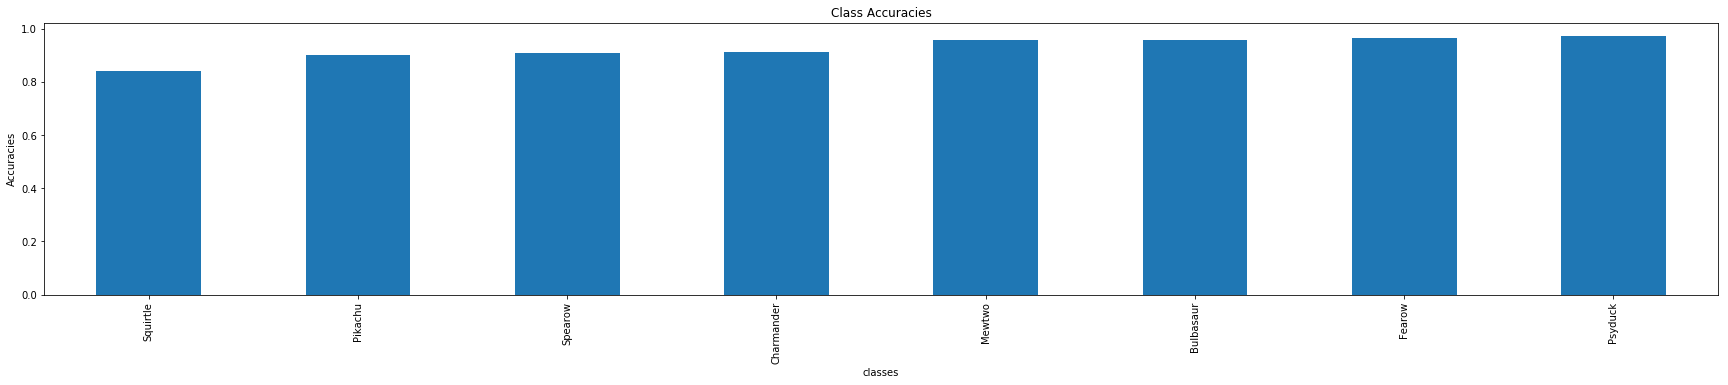

In [37]:
plot_acc_vs_class(acc_per_class, classes, sorted=True)

## Testing with individual images

Let's see what the model predicts for some hand-picked examples.

In [38]:
from random import shuffle

index = [x for x in range(100)]
shuffle(index)
index = iter(index)
# index = shuffle(index)

Label: Charmander 

Guess: Charmander  Probability: 100.000
Guess: Fearow      Probability: 0.000
Guess: Spearow     Probability: 0.000
Guess: Bulbasaur   Probability: 0.000
Guess: Pikachu     Probability: 0.000


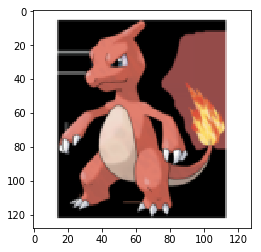

In [85]:
img, label = valid_ds2[next(index)]
plt.imshow(denormalize(img.unsqueeze(0), *stats).squeeze().permute(1, 2, 0).clamp(0, 1))

probs, preds = predict_image(img, model)
top_preds = [classes[x] for x in preds[0:5]]
percents = [100*prob for prob in probs]

print("Label:", classes[label], '\n')
str = ["Guess: {:11} Probability: {:.3f}".format(top_preds[i], percents[i]) for i in range(len(top_preds))]
for line in str:
    print(line)

# print('Label:', classes[label], ', Predicted:', predict_image(img, model))
# print('Label:', classes[label], ', Predicted:', top_preds, ', Probabilities:', percents)

haha! works 10% of the time, every time


Let's test on images found online:

In [74]:
from PIL import Image
import requests
from io import BytesIO
import sys
from importlib import reload
reload(plt)

# if 'img' in locals(): del img

# url = "https://static.wikia.nocookie.net/sonicpokemon/images/1/17/Quagsire.jpg/revision/latest/scale-to-width-down/640?cb=20130626042020"

def classify_from_url():
    # Get the image
    try:
        url = input("Enter the image url: ")
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img = img.convert('RGB')
    except:
        print("There was a problem obtaining the image.")
        sys.exit()

    # Convert to what the model expects
    img = valid_tfms(img)

    # Show the image
    denorm_image = denormalize(img, *stats).squeeze()
    plt.imshow(denorm_image.permute([1, 2, 0]).clamp(0, 1))
    plt.grid(None)

    # Get the prediction
    probs, preds = predict_image(img, model)
    top_preds = [classes[x] for x in preds[0:5]]
    percents = [100*prob for prob in probs]

    # Display the prediction
    string = ["Guess: {:11} Probability: {}".format(top_preds[i], percents[i]) for i in range(len(top_preds))]
    for line in string:
        print(line)

Guess: Fearow      Probability: 99.99998807907104
Guess: Charmander  Probability: 1.0056445631789757e-05
Guess: Squirtle    Probability: 4.063469560833255e-08
Guess: Pikachu     Probability: 1.563896373513174e-08
Guess: Mewtwo      Probability: 1.050863909779487e-08


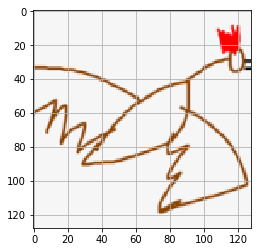

In [87]:
classify_from_url()